In [1]:
%pip install cvxpy
%pip install cvxopt
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 15.0 MB/s eta 0:00:0000:010:01m
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski
import math

import skimage.io
import skimage.transform

import scipy.fftpack as spfft

Original size:  (292, 228)
Rescaled size:  (53, 41)


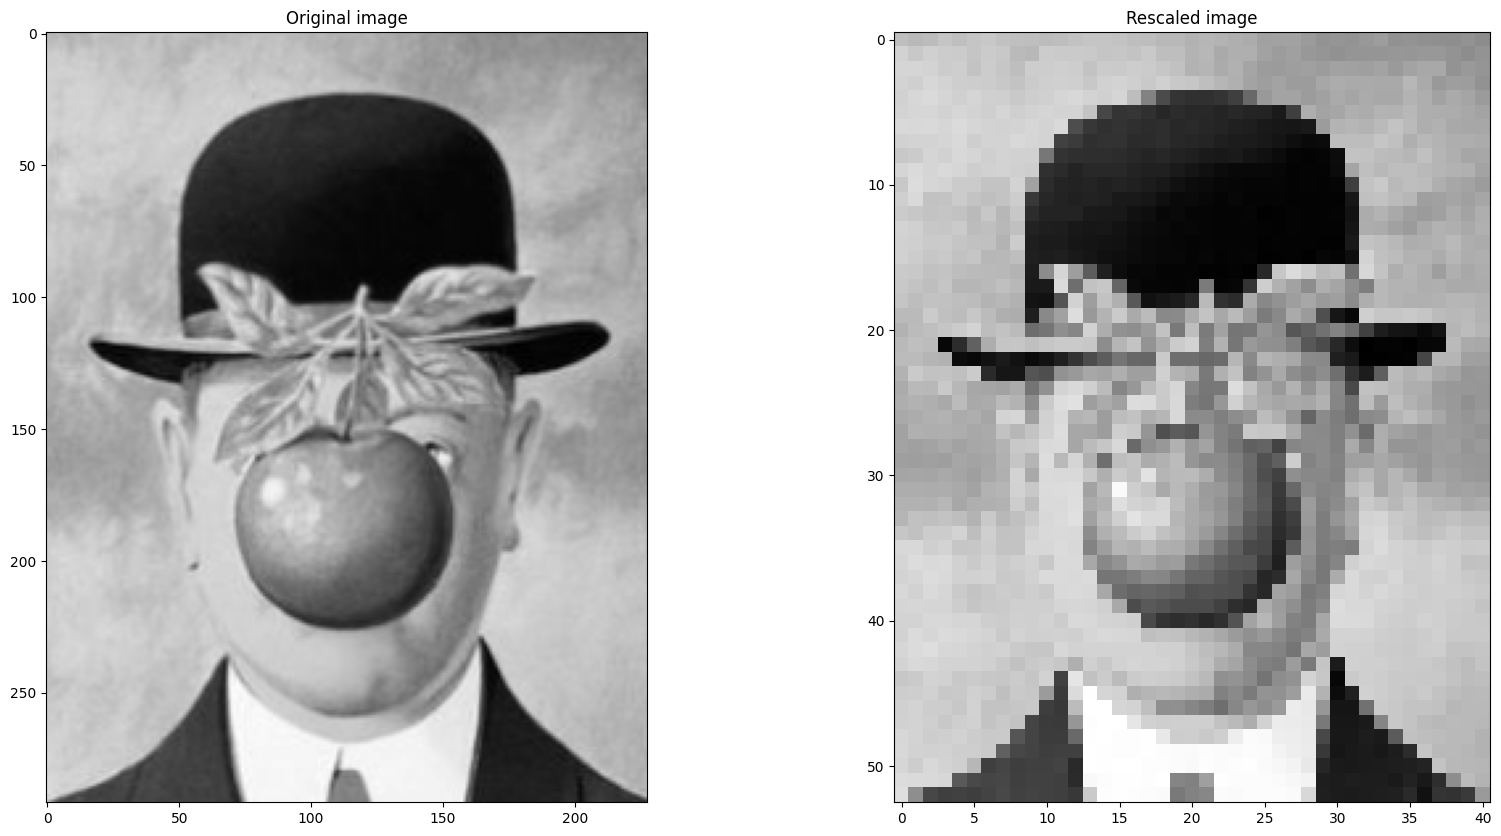

In [3]:
# Import image and rescale
img_path = '/Users/sunhaolou/Downloads/UW/Amath482/HW5/SonOfMan.png'

# Read image
img_og = ski.io.imread(img_path)

# Check if the image has an alpha channel and remove it if present
if img_og.shape[2] == 4:
    img_og = img_og[:, :, :3]

# Convert to grayscale and visualize
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_og, cmap='gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# Resize image
img = ski.transform.rescale(img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")
fig.savefig('original_img.png')

In [4]:
# constrauct forward and inverse DCT matrices

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image
  #         Ny number of rows of image

  # output: D DCT matrix mapping image.flatten() to
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image
  #         Ny number of rows of image

  # output: iD iDCT matrix mapping DCT(image).flatten() to
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

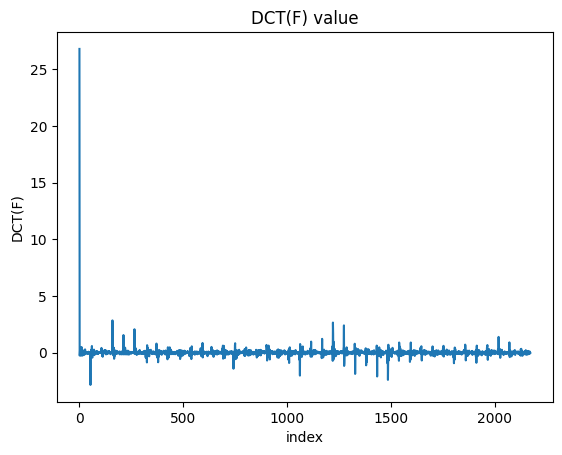

In [5]:
vec_F = np.ndarray.flatten(img)
DCT = construct_DCT_Mat(53, 41)
iDCT = construct_iDCT_Mat(53, 41)
DCT_F = np.matmul(DCT, vec_F)
plt.plot(DCT_F)
plt.title('DCT(F) value')
plt.xlabel('index')
plt.ylabel('DCT(F)')
plt.savefig('DCT_value.png')

In [6]:
sorted_DCT_F = np.sort(abs(DCT_F), axis=None)
sorted_DCT_F = sorted_DCT_F[::-1]
top_5 = sorted_DCT_F[0:math.floor(0.05*len(sorted_DCT_F))]
top_10 = sorted_DCT_F[0:math.floor(0.1*len(sorted_DCT_F))]
top_20 = sorted_DCT_F[0:math.floor(0.2*len(sorted_DCT_F))]
top_40 = sorted_DCT_F[0:math.floor(0.4*len(sorted_DCT_F))]

In [7]:
top_5_thre = top_5[len(top_5) - 1]
top_10_thre = top_10[len(top_10) - 1]
top_20_thre = top_20[len(top_20) - 1]
top_40_thre = top_40[len(top_40) - 1]

In [8]:
DCT_F_5 = np.copy(DCT_F)
DCT_F_10 = np.copy(DCT_F)
DCT_F_20 = np.copy(DCT_F)
DCT_F_40 = np.copy(DCT_F)
for i in range(len(DCT_F)):
    if abs(DCT_F_5[i]) < top_5_thre:
        DCT_F_5[i] = 0
    if abs(DCT_F_10[i]) < top_10_thre:
        DCT_F_10[i] = 0
    if abs(DCT_F_20[i]) < top_20_thre:
        DCT_F_20[i] = 0
    if abs(DCT_F_40[i]) < top_40_thre:
        DCT_F_40[i] = 0

image_5 = np.matmul(iDCT, DCT_F_5).reshape(53,41)
image_10 = np.matmul(iDCT, DCT_F_10).reshape(53,41)
image_20 = np.matmul(iDCT, DCT_F_20).reshape(53,41)
image_40 = np.matmul(iDCT, DCT_F_40).reshape(53,41)

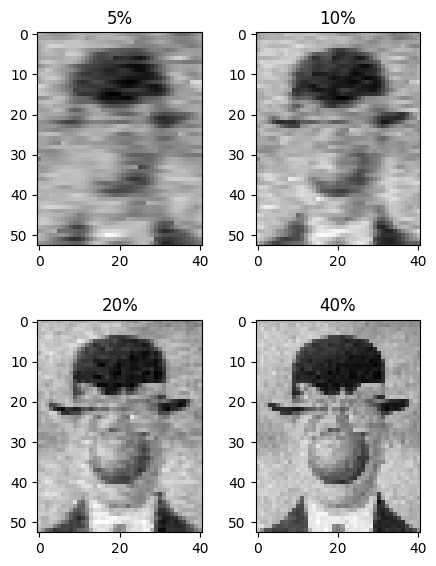

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].imshow(image_5, cmap = 'gray')
ax[0,0].set_title("5%")
ax[0,1].imshow(image_10, cmap='gray')
ax[0,1].set_title("10%")
ax[1,0].imshow(image_20, cmap='gray')
ax[1,0].set_title("20%")
ax[1,1].imshow(image_40, cmap='gray')
ax[1,1].set_title("40%")
plt.subplots_adjust(left=0.4,
                    bottom=0.1,
                    right=0.6,
                    top=0.6,
                    wspace=0.2,
                    hspace=0.35)
fig.savefig('Top_x_percent_imag.png')

In [10]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l1 = cvx.Minimize(cvx.norm(x,1))
constraints_l1 = [A*x == y]
prob_l1 = cvx.Problem(objective_l1, constraints_l1)
prob_l1.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l1 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:52:42 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 06 04:52:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:52:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:52:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:52:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:52:42 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:52:42 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 04:52:42 PM: Finished problem compilation (took 3.286e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:52:42 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3741e-13  1.4500e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1009e+01  3.1135e+01  6e+03  2e+02  3e-16  5e-01
 2:  4.5895e+01  4.6211e+01  2e+03  6e+01  2e-16  5e-01
 3:  7.8810e+01  7.8922e+01  7e+02  2e+01  3e-16  2e-01
 4:  1.1329e+02  1.1334e+02  3e+02  1e+01  4e-16  7e-02
 5:  1.3135e+02  1.3137e+02  1e+02  4e+00  5e-16  3e-02
 6:  1.3901e+02  1.3902e+02  7e+01  2e+00  5e-16  2e-02
 7:  1.4287e+02  1.4287e+02  3e+01  9e-01  5e-16  7e-03
 8:  1.4448e+02  1.4449e+02  1e+01  4e-01  6e-1

In [11]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l2 = cvx.Minimize(cvx.norm(x,1))
constraints_l2 = [A*x == y]
prob_l2 = cvx.Problem(objective_l2, constraints_l2)
prob_l2.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l2 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:53:43 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 06 04:53:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:53:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:53:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:53:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:53:43 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:53:43 PM: Finished problem compilation (took 2.972e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:53:43 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5211e-13  1.5940e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1853e+01  3.1985e+01  6e+03  2e+02  2e-16  6e-01
 2:  4.5984e+01  4.6318e+01  2e+03  6e+01  3e-16  5e-01
 3:  7.6433e+01  7.6559e+01  8e+02  2e+01  6e-16  2e-01
 4:  1.0580e+02  1.0586e+02  4e+02  1e+01  4e-16  9e-02
 5:  1.2793e+02  1.2796e+02  1e+02  4e+00  6e-16  3e-02
 6:  1.3635e+02  1.3636e+02  7e+01  2e+00  8e-16  2e-02
 7:  1.4050e+02  1.4051e+02  3e+01  8e-01  5e-16  6e-03
 8:  1.4197e+02  1.4197e+02  1e+01  4e-01  6e-16  3e-03
 9:  1.4264e+02  1.4264e+02  6e+00  2e-01  5e

In [12]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l3 = cvx.Minimize(cvx.norm(x,1))
constraints_l3 = [A*x == y]
prob_l3 = cvx.Problem(objective_l3, constraints_l3)
prob_l3.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l3 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:54:40 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 06 04:54:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:54:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:54:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:54:40 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:54:40 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:54:40 PM: Finished problem compilation (took 2.353e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:54:40 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6168e-13  1.5583e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1887e+01  3.2020e+01  6e+03  2e+02  3e-16  6e-01
 2:  4.5734e+01  4.6070e+01  2e+03  6e+01  3e-16  5e-01
 3:  7.8392e+01  7.8501e+01  7e+02  2e+01  3e-16  2e-01
 4:  1.1082e+02  1.1087e+02  3e+02  9e+00  5e-16  7e-02
 5:  1.2899e+02  1.2901e+02  1e+02  4e+00  5e-16  3e-02
 6:  1.3742e+02  1.3743e+02  5e+01  2e+00  5e-16  1e-02
 7:  1.4002e+02  1.4003e+02  2e+01  7e-01  6e-16  6e-03
 8:  1.4150e+02  1.4151e+02  9e+00  3e-01  6e-16  2e-03
 9:  1.4203e+02  1.4203e+02  5e+00  1e-01  7e

In [13]:
recovery_l1 = recovery_l1.reshape(53,41)
recovery_l2 = recovery_l2.reshape(53,41)
recovery_l3 = recovery_l3.reshape(53,41)

In [14]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l4 = cvx.Minimize(cvx.norm(x,1))
constraints_l4 = [A*x == y]
prob_l4 = cvx.Problem(objective_l4, constraints_l4)
prob_l4.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l4 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:55:43 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 06 04:55:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:55:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:55:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:55:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:55:43 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:55:43 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 04:55:44 PM: Finished problem compilation (took 4.648e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:55:44 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4675e-13  2.7398e-13  3e+04  8e+02  6e-16  1e+00
 1:  3.2266e+01  3.2608e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.2548e+01  5.2733e+01  2e+03  5e+01  2e-16  2e-01
 3:  1.1350e+02  1.1358e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.6519e+02  1.6522e+02  2e+02  6e+00  6e-16  3e-02
 5:  1.8638e+02  1.8639e+02  8e+01  2e+00  8e-16  1e-02
 6:  1.9538e+02  1.9538e+02  3e+01  1e+00  8e-16  6e-03
 7:  1.9904e+02  1.9904e+02  1e+01  4e-01  9e-16  3e-03
 8:  2.0054e+02  2.0054e+02  5e+00  2e-01  9e-1

In [15]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l5 = cvx.Minimize(cvx.norm(x,1))
constraints_l5 = [A*x == y]
prob_l5 = cvx.Problem(objective_l5, constraints_l5)
prob_l5.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l5 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:57:11 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 06 04:57:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:57:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:57:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:57:11 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:57:11 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:57:11 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 04:57:11 PM: Finished problem compilation (took 5.050e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:57:11 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6749e-13  2.7814e-13  3e+04  8e+02  6e-16  1e+00
 1:  3.2130e+01  3.2473e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1891e+01  5.2076e+01  2e+03  5e+01  2e-16  2e-01
 3:  1.0992e+02  1.0999e+02  6e+02  2e+01  5e-16  1e-01
 4:  1.6346e+02  1.6349e+02  2e+02  6e+00  6e-16  3e-02
 5:  1.8628e+02  1.8629e+02  9e+01  3e+00  7e-16  2e-02
 6:  1.9664e+02  1.9665e+02  3e+01  1e+00  8e-16  7e-03
 7:  2.0020e+02  2.0020e+02  2e+01  5e-01  9e-16  3e-03
 8:  2.0180e+02  2.0180e+02  7e+00  2e-01  9e-1

In [16]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l6 = cvx.Minimize(cvx.norm(x,1))
constraints_l6 = [A*x == y]
prob_l6 = cvx.Problem(objective_l6, constraints_l6)
prob_l6.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l6 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:58:31 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 06 04:58:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:58:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:58:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:58:31 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:58:31 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:58:31 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 04:58:32 PM: Finished problem compilation (took 4.816e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:58:32 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8533e-13  2.4403e-13  3e+04  8e+02  6e-16  1e+00
 1:  3.2567e+01  3.2916e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.2290e+01  5.2478e+01  2e+03  5e+01  3e-16  2e-01
 3:  1.1188e+02  1.1196e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.6389e+02  1.6392e+02  2e+02  6e+00  7e-16  3e-02
 5:  1.8780e+02  1.8781e+02  8e+01  2e+00  8e-16  1e-02
 6:  1.9633e+02  1.9633e+02  3e+01  9e-01  8e-16  6e-03
 7:  1.9951e+02  1.9952e+02  1e+01  4e-01  9e-16  3e-03
 8:  2.0118e+02  2.0118e+02  5e+00  2e-01  9e-1

In [17]:
recovery_l4 = recovery_l4.reshape(53,41)
recovery_l5 = recovery_l5.reshape(53,41)
recovery_l6 = recovery_l6.reshape(53,41)

In [18]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l7 = cvx.Minimize(cvx.norm(x,1))
constraints_l7 = [A*x == y]
prob_l7 = cvx.Problem(objective_l7, constraints_l7)
prob_l7.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l7 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 04:59:59 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 06 04:59:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 04:59:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 04:59:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 04:59:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 04:59:59 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 04:59:59 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 05:00:00 PM: Finished problem compilation (took 6.385e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:00:00 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6085e-13  3.7010e-13  4e+04  1e+03  7e-16  1e+00
 1:  3.2671e+01  3.3288e+01  1e+04  4e+02  4e-16  1e+00
 2:  5.4762e+01  5.4867e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2738e+02  1.2743e+02  6e+02  2e+01  4e-16  6e-02
 4:  1.9664e+02  1.9666e+02  2e+02  5e+00  8e-16  2e-02
 5:  2.2686e+02  2.2686e+02  6e+01  2e+00  1e-15  7e-03
 6:  2.3599e+02  2.3599e+02  3e+01  9e-01  1e-15  4e-03
 7:  2.4082e+02  2.4082e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4279e+02  2.4279e+02  5e+00  1e-01  1e-1

In [19]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l8 = cvx.Minimize(cvx.norm(x,1))
constraints_l8 = [A*x == y]
prob_l8 = cvx.Problem(objective_l8, constraints_l8)
prob_l8.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l8 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 05:01:43 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 06 05:01:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 05:01:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 05:01:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 05:01:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:01:43 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 05:01:43 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 05:01:43 PM: Finished problem compilation (took 6.212e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:01:43 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.0008e-13  3.0375e-13  4e+04  1e+03  8e-16  1e+00
 1:  3.2813e+01  3.3426e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.5595e+01  5.5700e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2857e+02  1.2861e+02  6e+02  2e+01  5e-16  6e-02
 4:  1.9196e+02  1.9197e+02  2e+02  6e+00  8e-16  2e-02
 5:  2.2266e+02  2.2267e+02  7e+01  2e+00  9e-16  8e-03
 6:  2.3441e+02  2.3441e+02  3e+01  8e-01  1e-15  4e-03
 7:  2.3879e+02  2.3879e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4023e+02  2.4023e+02  4e+00  1e-01  1e-1

In [20]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l9 = cvx.Minimize(cvx.norm(x,1))
constraints_l9 = [A*x == y]
prob_l9 = cvx.Problem(objective_l9, constraints_l9)
prob_l9.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l9 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 05:03:30 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 06 05:03:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 05:03:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 05:03:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 05:03:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:03:30 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 05:03:31 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 05:03:31 PM: Finished problem compilation (took 6.692e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:03:31 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.2660e-13  2.6520e-13  4e+04  1e+03  7e-16  1e+00
 1:  3.2864e+01  3.3482e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.5072e+01  5.5183e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2348e+02  1.2352e+02  6e+02  2e+01  5e-16  6e-02
 4:  1.9488e+02  1.9489e+02  2e+02  5e+00  9e-16  2e-02
 5:  2.2722e+02  2.2722e+02  6e+01  2e+00  1e-15  8e-03
 6:  2.3805e+02  2.3805e+02  3e+01  8e-01  1e-15  4e-03
 7:  2.4241e+02  2.4241e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4419e+02  2.4419e+02  4e+00  1e-01  1e-1

In [21]:
recovery_l7 = recovery_l7.reshape(53,41)
recovery_l8 = recovery_l8.reshape(53,41)
recovery_l9 = recovery_l9.reshape(53,41)

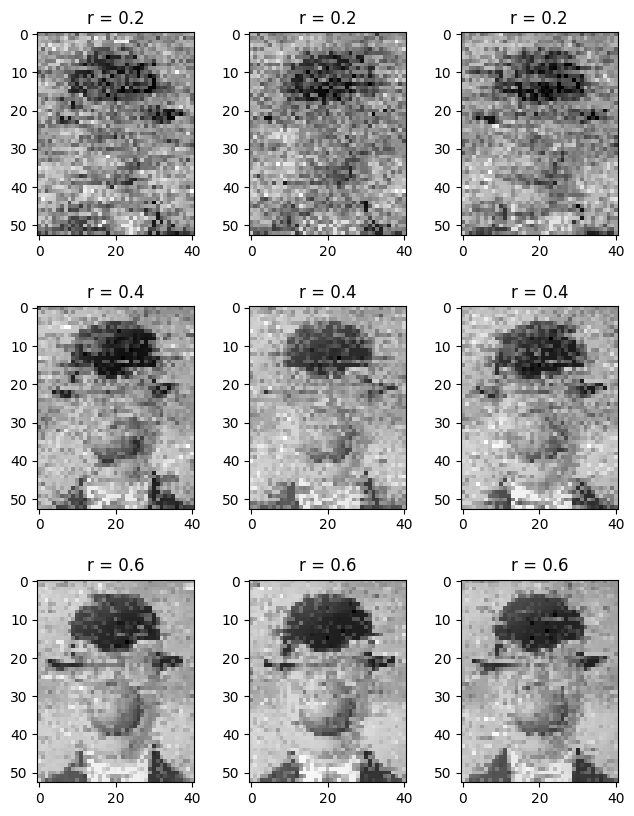

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(30,15))
ax[0, 0].imshow(recovery_l1, cmap = 'gray')
ax[0, 0].set_title("r = 0.2")
ax[0, 1].imshow(recovery_l2, cmap = 'gray')
ax[0, 1].set_title("r = 0.2")
ax[0, 2].imshow(recovery_l3, cmap = 'gray')
ax[0, 2].set_title("r = 0.2")
ax[1, 0].imshow(recovery_l4, cmap = 'gray')
ax[1, 0].set_title("r = 0.4")
ax[1, 1].imshow(recovery_l5, cmap = 'gray')
ax[1, 1].set_title("r = 0.4")
ax[1, 2].imshow(recovery_l6, cmap = 'gray')
ax[1, 2].set_title("r = 0.4")
ax[2, 0].imshow(recovery_l7, cmap = 'gray')
ax[2, 0].set_title("r = 0.6")
ax[2, 1].imshow(recovery_l8, cmap = 'gray')
ax[2, 1].set_title("r = 0.6")
ax[2, 2].imshow(recovery_l9, cmap = 'gray')
ax[2, 2].set_title("r = 0.6")
plt.subplots_adjust(left=0.4,
                    bottom=0.1,
                    right=0.6,
                    top=0.6,
                    wspace=0.2,
                    hspace=0.35)
fig.savefig('Image_different_M.png')

In [23]:
path = '/Users/sunhaolou/Downloads/UW/Amath482/HW5/UnknownImage.npz'
data = np.load(path)
B = data['B']
y = data['y']
DCT = construct_DCT_Mat(50, 50)
iDCT = construct_iDCT_Mat(50, 50)
A = np.dot(B, iDCT)
x = cvx.Variable(2500)
objective = cvx.Minimize(cvx.norm(x,1))
constraints = [A*x == y]
prob = cvx.Problem(objective, constraints)
prob.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_unknown = np.matmul(iDCT, x.value)
recovery_unknown = recovery_unknown.reshape(50, 50)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 06 05:05:17 PM: Your problem has 2500 variables, 2000 constraints, and 0 parameters.
(CVXPY) Jul 06 05:05:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 06 05:05:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 06 05:05:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 06 05:05:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:05:17 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 06 05:05:18 PM: Applying reduction CVXOPT
(CVXPY) Jul 06 05:05:18 PM: Finished problem compilation (took 1.296e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 06 05:05:18 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1719e-14  1.0193e-15  3e+04  1e+03  9e-16  1e+00
 1:  2.9658e+01  3.0189e+01  1e+04  3e+02  3e-16  8e-01
 2:  7.2764e+01  7.2857e+01  1e+03  4e+01  4e-16  1e-01
 3:  2.0177e+02  2.0179e+02  3e+02  8e+00  1e-15  3e-02
 4:  2.8074e+02  2.8075e+02  1e+02  3e+00  2e-15  1e-02
 5:  3.0448e+02  3.0449e+02  4e+01  1e+00  2e-15  5e-03
 6:  3.1328e+02  3.1329e+02  2e+01  6e-01  2e-15  3e-03
 7:  3.1837e+02  3.1837e+02  8e+00  2e-01  3e-15  1e-03
 8:  3.2029e+02  3.2029e+02  3e+00  9e-02  3e-1

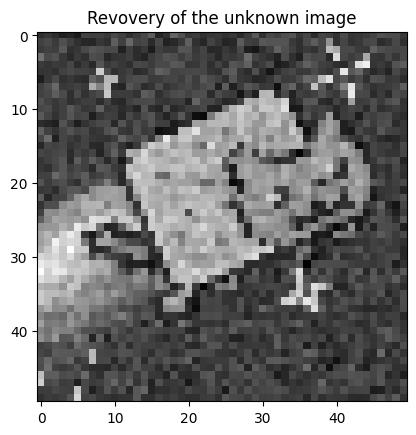

In [24]:
plt.imshow(recovery_unknown, cmap = 'gray')
plt.title('Revovery of the unknown image')
plt.savefig('recovery_unknown.png')